### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost
import pickle
from difflib import get_close_matches
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Data Import, Cleaning & Grouping
- Import and Peak at Raw Data
- Analyze Null Values
- Grouping/Cleaning

#### Import and Peak at Raw Data

In [4]:
pokemon_raw = pd.read_csv('pokemon.csv')
combat_raw = pd.read_csv('combats.csv')

In [5]:
# Peak at Pokemon Raw
pokemon_raw.head(10)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
5,6,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False
6,7,Charizard,Fire,Flying,78,84,78,109,85,100,1,False
7,8,Mega Charizard X,Fire,Dragon,78,130,111,130,85,100,1,False
8,9,Mega Charizard Y,Fire,Flying,78,104,78,159,115,100,1,False
9,10,Squirtle,Water,NaN,44,48,65,50,64,43,1,False


Right off the bat, we can see that there are null values in the Type 2 column. This is expected however since not all pokemon have dual typing. We will still need to figure out a way to handle this null data when we encode the column for machine learning.

Including the type columns, it looks like we have 10 features to select from when building our model. We won't include the Name column because it does not tell us anything insightful. We will also run some correlation analysis to see which features to select when building our model.

In [6]:
# Peak at Comabats Raw
combat_raw.head(5)

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


The combats data is pretty straightforward, the pokedex number of two pokemon that battled and the winner column lists the pokemon that one said battle.

Before we group our data to prepare it for machine learning, let's take a look at any other nulls we might have to address before moving forward.

#### Analyze Null Values

In [7]:
# Find nulls
pokemon_raw.isnull().sum()

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Almost all of our nulls exist in the Type 2 column, which we said before makes sense since not all pokemon have dual typing. However there is one pokemon that is missing its name. Let's see which pokemon that is and fix the issue.

In [8]:
pokemon_raw[pokemon_raw['Name'].isnull()]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False


We see that the pokedex number for this pokemon is number 63. I don't know which pokemon that is off the top of my head, but maybe looking at the surrounding pokemon will give us a better idea.

In [9]:
pokemon_raw[pokemon_raw['#'].isin(['61','62','63','64','65'])]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
60,61,Golduck,Water,NaN,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False
64,65,Arcanine,Fire,NaN,90,110,80,100,80,95,1,False


We see that the missing pokemon is in between Mankey and Growlithe. From previous experience, I know that Mankey's evolution is Primeape, and that should be filled in for the Null value. Let's do that now!

In [10]:
pokemon_raw['Name'][62] = 'Primeape'
pokemon_raw.isnull().sum() #this should list that only nulls exist in Type 2

#               0
Name            0
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

#### Grouping/Cleaning

In [11]:
# Group combat table by wins
winner = combat_raw.groupby('Winner').size()
winner = winner.to_frame().reset_index()
winner.rename(columns={0: 'NumberWins'}, inplace=True)
winner.head()

,Winner,NumberWins
0,1,37
1,2,46
2,3,89
3,4,70
4,5,55


In [12]:
# Create a loser column and group by loser
losers = []
for index, row in combat_raw.iterrows():
    if row['Winner'] == row['First_pokemon']:
        losers.append(row['Second_pokemon'])
    else:
        losers.append(row['First_pokemon'])
combat_raw['Loser'] = losers

loser = combat_raw.groupby('Loser').size()
loser = loser.to_frame().reset_index()
loser.rename(columns={0:'NumberLosses'}, inplace=True)
loser.head()

,Loser,NumberLosses
0,1,96
1,2,75
2,3,43
3,4,55
4,5,57


In [13]:
# Join Wins and Losses to main table
win_loss = pokemon_raw.copy()

win_loss = win_loss.merge(winner, how='left', left_on='#', right_on='Winner')
win_loss = win_loss.merge(loser, how='left', left_on='#', right_on='Loser')
win_loss.drop(columns={'Winner', 'Loser'}, inplace=True)
win_loss['WinRate'] = win_loss['NumberWins'] / (win_loss['NumberWins'] + win_loss['NumberLosses'])
win_loss.head(10)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,NumberWins,NumberLosses,WinRate
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37.0,96.0,0.278195
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46.0,75.0,0.380165
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89.0,43.0,0.674242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,70.0,55.0,0.560000
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,55.0,57.0,0.491071
5,6,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False,64.0,54.0,0.542373
6,7,Charizard,Fire,Flying,78,84,78,109,85,100,1,False,115.0,18.0,0.864662
7,8,Mega Charizard X,Fire,Dragon,78,130,111,130,85,100,1,False,119.0,20.0,0.856115
8,9,Mega Charizard Y,Fire,Flying,78,104,78,159,115,100,1,False,114.0,21.0,0.844444
9,10,Squirtle,Water,NaN,44,48,65,50,64,43,1,False,19.0,98.0,0.162393


Now we have pulled in total wins, losses and a win rate for each pokemon. Let's do a quick group by to see wins by type in the Type 1 column.

In [14]:
win_loss.groupby('Type 1').agg({'WinRate': 'mean'}).sort_values('WinRate').head(20)

,WinRate
Type 1,
Fairy,0.329300
Rock,0.404852
Steel,0.424529
Poison,0.433262
Bug,0.439006
Ice,0.439604
Grass,0.440364
Water,0.469357
Fighting,0.475616


Dragon being one of the top winning pokemon is definitely not suprising, but seeing the Flying type top this chart is definitely interesting!

Now that we have done some initial analysis, let's do some correlation analysis to try to select the most relevant features when building our model.

### Correlation Analysis

In [15]:
# Correlation Table
col = ['Type 1','HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'WinRate']
win_loss.loc[:,col].corr()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,WinRate
HP,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.258006
Attack,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.500181
Defense,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.129426
Sp. Atk,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.478940
Sp. Def,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.324218
Speed,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,0.937742
WinRate,0.258006,0.500181,0.129426,0.478940,0.324218,0.937742,1.000000


It looks like Attack, Sp. Attack and Speed have the most correlation to win rate. Since Speed looks to have the highest correlation to win rate, let's visualize this.

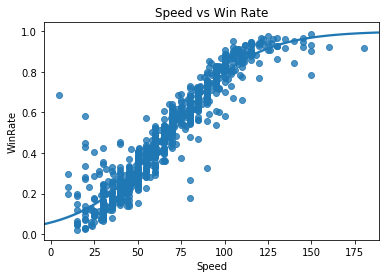

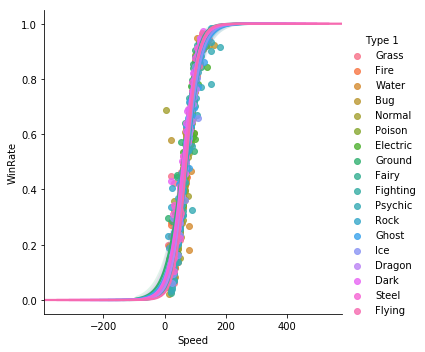

In [16]:
# Correlation Graph
sns.regplot(x="Speed", y="WinRate", data=win_loss, logistic=True).set_title("Speed vs Win Rate")
sns.lmplot(x="Speed", y="WinRate", data=win_loss, hue = 'Type 1',  logistic=True)#.set_title("Speed vs Win Percentage")

Although it's not visible here, we also know that Type and whether a pokemon is Legendary or not has a significant effect on the outcome of a battle. We will also want to include these as features along with Attack, Sp. Attack and Speed.

Now that we have finished some initial cleaning and grouping, we still need to prepare our data to be digestible by ML models. More specifically, we need to encode some columns to integer columns.

First, let's create a table based off the combats table. This table will have all the information from the raw combats table, but will also have the stats that we want (Attack, Sp. Attack, Speed, Type, Legendary) for each pokemon.

### Data Preprocessing
- Create a digestible dataset
- Encoding necessary columns
- Split data into training and test sets

#### Merge and Encoding

In [17]:
combats = combat_raw.copy()
cols = ['#', 'Type 1', 'Type 2', 'Attack', 'Sp. Atk', 'Speed', 'Legendary']
combats = combats.merge(pokemon_raw[cols], left_on='First_pokemon', right_on='#', how='left')
combats.drop(columns={'Loser', '#'}, inplace=True)

# Encode Legendary Column
combats['Legendary'] = combats['Legendary'].astype(int)

# Rename Columns
combats.columns = [x + ' - poke1' if x in cols else x for x in combats.columns.to_list()]

# Join in stats for pokemon 2
combats = combats.merge(pokemon_raw[cols], left_on='Second_pokemon', right_on='#', how='left')
combats.drop(columns={'#'}, inplace=True)

# Encode Legendary Column
combats['Legendary'] = combats['Legendary'].astype(int)

# Rename Columns
combats.columns = [x + ' - poke2' if x in cols else x for x in combats.columns.to_list()]
combats.head()

# Reorder columns
cols = combats.columns.to_list()
cols = [cols[0]] + cols[3:9] + [cols[1]] + cols[9:] + [cols[2]]
combats = combats[cols]
combats.head(10)

,First_pokemon,Type 1 - poke1,Type 2 - poke1,Attack - poke1,Sp. Atk - poke1,Speed - poke1,Legendary - poke1,Second_pokemon,Type 1 - poke2,Type 2 - poke2,Attack - poke2,Sp. Atk - poke2,Speed - poke2,Legendary - poke2,Winner
0,266,Rock,Ground,64,45,41,0,298,Grass,Dark,70,60,60,0,298
1,702,Grass,Fighting,90,90,108,1,701,Rock,Fighting,129,72,108,1,701
2,191,Fairy,Flying,40,80,40,0,668,Psychic,NaN,75,125,40,0,668
3,237,Fire,NaN,40,70,20,0,683,Dragon,NaN,120,60,48,0,683
4,151,Rock,Water,60,115,55,0,231,Bug,Rock,10,10,5,0,151
5,657,Bug,Electric,47,57,65,0,752,Steel,Ghost,50,50,60,0,657
6,192,Psychic,Flying,50,70,70,0,134,Ice,Psychic,50,115,95,0,134
7,73,Fighting,NaN,80,35,35,0,545,Ghost,Dragon,100,100,90,1,545
8,220,Bug,NaN,65,35,15,0,763,Water,NaN,53,58,44,0,763
9,302,Water,Flying,30,55,85,0,31,Electric,NaN,55,50,90,0,31


Now that we have stats for each pokemon involved in the battle and have encoded the Legendary column, we are almost ready to build and compare models. However, we still need to encode both Type columns for our data to be digestible.

Let's first make sure that the only nulls that exist are in the Type 2 column.

In [18]:
combats.isnull().sum()

First_pokemon            0
Type 1 - poke1           0
Type 2 - poke1       24031
Attack - poke1           0
Sp. Atk - poke1          0
Speed - poke1            0
Legendary - poke1        0
Second_pokemon           0
Type 1 - poke2           0
Type 2 - poke2       23985
Attack - poke2           0
Sp. Atk - poke2          0
Speed - poke2            0
Legendary - poke2        0
Winner                   0
dtype: int64

Now that we know only nulls exist in the Type 2 column, we still need to change the NaN values with a string so that it can be encoded.

In [19]:
combats.fillna('None', inplace=True)
combats.isnull().sum()

First_pokemon        0
Type 1 - poke1       0
Type 2 - poke1       0
Attack - poke1       0
Sp. Atk - poke1      0
Speed - poke1        0
Legendary - poke1    0
Second_pokemon       0
Type 1 - poke2       0
Type 2 - poke2       0
Attack - poke2       0
Sp. Atk - poke2      0
Speed - poke2        0
Legendary - poke2    0
Winner               0
dtype: int64

Now that we have replaced all Null values with a string in Type 2, let's encode!

In [20]:
# Turn types into a dictionary
types_1 = pokemon_raw['Type 1'].to_list()
types_2 = pokemon_raw['Type 2'].to_list()
types = list(set(types_1 + types_2))
types[0] = 'None'
types = pd.DataFrame({'Type': types})
types['Type_Code'] = LabelEncoder().fit_transform(types['Type'])
types = dict(zip(types['Type'], types['Type_Code'])) # turn to dict
types

{'None': 12,
 'Electric': 3,
 'Rock': 16,
 'Flying': 7,
 'Fire': 6,
 'Water': 18,
 'Fairy': 4,
 'Steel': 17,
 'Grass': 9,
 'Normal': 13,
 'Dragon': 2,
 'Dark': 1,
 'Ground': 10,
 'Ghost': 8,
 'Fighting': 5,
 'Psychic': 15,
 'Poison': 14,
 'Ice': 11,
 'Bug': 0}

In [21]:
# Replace type with encoded integer in combat table
combats_encoded = combats.copy()

type_col = ['Type 1 - poke1', 'Type 2 - poke1', 'Type 1 - poke2', 'Type 2 - poke2']
for col in type_col:
    combats_encoded[col].replace(types, inplace=True)

combats_encoded.head()

,First_pokemon,Type 1 - poke1,Type 2 - poke1,Attack - poke1,Sp. Atk - poke1,Speed - poke1,Legendary - poke1,Second_pokemon,Type 1 - poke2,Type 2 - poke2,Attack - poke2,Sp. Atk - poke2,Speed - poke2,Legendary - poke2,Winner
0,266,16,10,64,45,41,0,298,9,1,70,60,60,0,298
1,702,9,5,90,90,108,1,701,16,5,129,72,108,1,701
2,191,4,7,40,80,40,0,668,15,12,75,125,40,0,668
3,237,6,12,40,70,20,0,683,2,12,120,60,48,0,683
4,151,16,18,60,115,55,0,231,0,16,10,10,5,0,151


Now that the type column is encoded, the last step is to encode the winner column. We want the table to show 0 if pokemon 1 won, and 1 if pokemon 2 won.

In [22]:
# If First wins, then 0. If Second wins, then 1
combats_encoded.Winner[combats_encoded.Winner == combats_encoded.First_pokemon] = 0
combats_encoded.Winner[combats_encoded.Winner == combats_encoded.Second_pokemon] = 1

# Drop the pokemon # columns
combats_encoded.drop(columns={'First_pokemon', 'Second_pokemon'}, inplace=True)
combats_encoded.head()

,Type 1 - poke1,Type 2 - poke1,Attack - poke1,Sp. Atk - poke1,Speed - poke1,Legendary - poke1,Type 1 - poke2,Type 2 - poke2,Attack - poke2,Sp. Atk - poke2,Speed - poke2,Legendary - poke2,Winner
0,16,10,64,45,41,0,9,1,70,60,60,0,1
1,9,5,90,90,108,1,16,5,129,72,108,1,1
2,4,7,40,80,40,0,15,12,75,125,40,0,1
3,6,12,40,70,20,0,2,12,120,60,48,0,1
4,16,18,60,115,55,0,0,16,10,10,5,0,0


#### Split into Train and Test

In [23]:
X = combats_encoded.iloc[:, :12].values
y = combats_encoded.iloc[:, 12].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Model Comparison & Selection
We are interested in building a model that takes two pokemon and tries to predict the winner between the two. Since we are trying to see whether Pokemon A won or lost against Pokemon B, we will compare various classification models.

#### Decision Tree Classifier

In [24]:
model_1 = DecisionTreeClassifier()
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)
model_1_score = accuracy_score(y_test, y_pred_1)
model_1_mae = mean_absolute_error(y_test, y_pred_1)
print('Model 1 Accuracy: {}\nModel 1 MAE: {}'.format(model_1_score, model_1_mae))

Model 1 Accuracy: 0.9347
Model 1 MAE: 0.0653


#### Random Forest Classifier

In [25]:
model_2 = RandomForestClassifier(n_estimators=100)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
model_2_score = accuracy_score(y_test, y_pred_2)
model_2_mae = mean_absolute_error(y_test, y_pred_2)
print('Model 2 Accuracy: {}\nModel 2 MAE: {}'.format(model_2_score, model_2_mae))

Model 2 Accuracy: 0.9511
Model 2 MAE: 0.0489


#### XGBoost

In [26]:
model_3 = xgboost.XGBClassifier()
model_3.fit(X_train, y_train)
y_pred_3 = model_3.predict(X_test)
model_3_score = accuracy_score(y_test, y_pred_3)
model_3_mae = mean_absolute_error(y_test, y_pred_3)
print('Model 3 Accuracy: {}\nModel 2 MAE: {}'.format(model_3_score, model_3_mae))

Model 3 Accuracy: 0.922
Model 2 MAE: 0.078


It looks like Random Forest was the best model based on our results. Although there are more models we can test, let's go ahead and move forward with the Random Forest classifier for this purpose.

### Put Model Into Practice
- Save & Load Model for future use
- Prepare raw pokemon table for lookup functionality
- Create helper functions to make querying easier
- Make predictions!

#### Save & Load Model

In [27]:
# Save
filename = 'model.sav'
pickle.dump(model_2, open(filename, 'wb'))

In [28]:
# Load
classifier = pickle.load(open(filename, 'rb'))

#### Preparing Raw Pokemon Table

In [29]:
# Encode Win Loss Table for types
cols = ['Type 1', 'Type 2']
pokemon_encoded = win_loss.copy()
pokemon_encoded.fillna('None', inplace=True)

# Encode Types
for col in cols:
    pokemon_encoded[col].replace(types, inplace=True)

# Encode Legendary
pokemon_encoded['Legendary'] = pokemon_encoded['Legendary'].astype(int)
pokemon_encoded.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,NumberWins,NumberLosses,WinRate
0,1,Bulbasaur,9,14,45,49,49,65,65,45,1,0,37,96,0.278195
1,2,Ivysaur,9,14,60,62,63,80,80,60,1,0,46,75,0.380165
2,3,Venusaur,9,14,80,82,83,100,100,80,1,0,89,43,0.674242
3,4,Mega Venusaur,9,14,80,100,123,122,120,80,1,0,70,55,0.56
4,5,Charmander,6,12,39,52,43,60,50,65,1,0,55,57,0.491071


#### Create Helper Functions

In [30]:
pokemon_list = pokemon_encoded['Name'].to_list()
cols = ['Type 1', 'Type 2', 'Attack', 'Sp. Atk', 'Speed', 'Legendary']

# search for closest match
def poke_search(name):
    poke = get_close_matches(name, pokemon_list, n=1)
    return(poke[0])

# get stats
def get_stats(name):
    stats = pokemon_encoded.loc[pokemon_encoded['Name'] == name, cols].values.flatten().tolist()
    return(stats)

#### Make Predictions!

In [31]:
poke_1 = poke_search('Charmander')
poke_2 = poke_search('Blastoise')

predict = get_stats(poke_1) + get_stats(poke_2)

result = classifier.predict([predict])

print('{} vs. {}: \n'.format(poke_1, poke_2))
if result == 0:
    print('{} wins!'.format(poke_1))
else:
    print('{} wins!'.format(poke_2))

Charmander vs. Blastoise: 

Blastoise wins!


Because Charmander is the first of it's evolutionary line, and has typing disadvantages against Blastoise - this is the expected result. Let's try to compare a Legendary vs Non Legendary Battle!

In [32]:
poke_1 = poke_search('Arcanine')
poke_2 = poke_search('Zapdos')

predict = get_stats(poke_1) + get_stats(poke_2)

result = classifier.predict([predict])

print('{} vs. {}: \n'.format(poke_1, poke_2))
if result == 0:
    print('{} wins!'.format(poke_1))
else:
    print('{} wins!'.format(poke_2))

Arcanine vs. Zapdos: 

Zapdos wins!


In [33]:
pokemon_raw[pokemon_raw['Name'].isin(['Zapdos', 'Arcanine'])]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
64,65,Arcanine,Fire,NaN,90,110,80,100,80,95,1,False
157,158,Zapdos,Electric,Flying,90,90,85,125,90,100,1,True


Although there are no typing advantages involved here, we can see that Zapdos has the advantage over Arcanine in Speed and Sp. Atk. Although Arcanine has the advantage in Attack, Zapdos being a Legendary also holds some weight in this victory.

Let's try a battle that is harder to predict: Non Legendary vs Non Legendary with no type advantages.

In [34]:
poke_1 = poke_search('Pidgeot')
poke_2 = poke_search('Fearow')

predict = get_stats(poke_1) + get_stats(poke_2)

result = classifier.predict([predict])

print('{} vs. {}: \n'.format(poke_1, poke_2))
if result == 0:
    print('{} wins!'.format(poke_1))
else:
    print('{} wins!'.format(poke_2))

Pidgeot vs. Fearow: 

Pidgeot wins!


In [35]:
pokemon_raw[pokemon_raw['Name'].isin(['Pidgeot', 'Fearow'])]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
22,23,Pidgeot,Normal,Flying,83,80,75,70,70,101,1,False
27,28,Fearow,Normal,Flying,65,90,65,61,61,100,1,False


Here, although Pidgeot and Fearow are both normal-flying types, it makes sense that Pidgeot is the victor in this battle. Although Fearow edges Pidgeot out in Attack, Pidgeot has Sp. Atk and Speed advantages over Fearow.

### Summary

In this notebook, we were able to turn some raw data in digestible data by cleaning, grouping and encoding. We also ran a quick correlation analysis to do simple feature selection and made visualizations that represented the correlation of Speed and Win Rate. Ultimately, we used our data to make predictions on the winner between two pokemon in a pokemon battle.

Also worth noting is that we made the assumption that Pokemon levels were equal when making predictions. The level of the pokemon affects these stats and would have a great impact on the outcomes of our predictions!